<a href="https://colab.research.google.com/github/diputs03/AI-Studies/blob/main/Creating_network/dymamic_architect_rebuilt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Aiming a Dynaimic Graph-structured NeuronNetwork
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
from collections import deque

In [6]:
"""
Activation function in this case in tanh
Loss is the Euclidean loss
"""
class Model:
  class Neuron:
    def __init__(self, name, prev, next):
      self.name, self.prev, self.next = name, prev, next
      self.bias = np.random.uniform(-0.1, 0.1)

  def __init__(self, input_size, output_size):
    self.input_size = input_size
    self.output_size = output_size
    self.Input_layer = [Model.Neuron(f"input{i}", [], []) for i in range(input_size)]
    self.Output_layer = [Model.Neuron(f"output{o}", [], []) for o in range(output_size)]
    for i in range(input_size): self.Input_layer[i].next = self.Output_layer
    for o in range(output_size): self.Output_layer[o].prev = self.Input_layer
    self.weight = {}
    for u in self.Input_layer:
      for v in self.Output_layer:
        self.weight[(u,v)] = np.random.uniform(-0.1, 0.1)
    self.all_neurons = self.Input_layer + self.Output_layer

  def forward(self, X, batch_size):
    assert X.shape == (batch_size,self.input_size)
    a = {q: [0 for _ in range(batch_size)] for q in self.all_neurons}

    for i, n in enumerate(self.Input_layer):
      a[n] = X[:, i]

    q = deque()
    for i in self.Input_layer:
      q.append(i)

    cnt = {q: 0 for q in self.all_neurons}

    while len(q) != 0:
      c = q.popleft()
      a[c] = np.tanh(a[c] + c.bias)
      for n in c.next:
        a[n] = a[n] + a[c]*self.weight[(c,n)]
        cnt[n] += 1
        if cnt[n] == len(n.prev):
          q.append(n)
    return a

  def eval(self, X):
    a = self.forward(X, len(X))
    return np.array([a[o] for o in self.Output_layer]).T

  def backward(self, X, Y, batch_size, learning_rate):
    assert X.shape == (batch_size,self.input_size)
    assert Y.shape == (batch_size,self.output_size)
    a = self.forward(X, batch_size)
    par_a = {q: [0 for _ in range(batch_size)] for q in self.all_neurons}
    for o, n in enumerate(self.Output_layer):
      par_a[n] = 2 * (a[n] - Y[:, o])

    q = deque()
    for o in self.Output_layer:
      q.append(o)

    cnt = {q: 0 for q in self.all_neurons}

    while len(q) != 0:
      c = q.popleft()
      par_b = par_a[c] * (1-a[c]**2)
      c.bias -= np.mean(par_b) * learning_rate
      for p in c.prev:
        par_a[p] += par_a[c] * (1-a[c]**2) * self.weight[(p,c)]
        par_w_pc = par_a[c] * (1-a[c]**2) * a[p]
        self.weight[(p,c)] -= np.mean(par_w_pc) * learning_rate
        cnt[p] += 1
        if cnt[p] == len(p.next):
          q.append(p)

  def addLayer(self, mid_size, UP, DOWN):
    Mid_layer = [Model.Neuron(f"mid{o}", [], []) for o in range(mid_size)]
    for m, mid in enumerate(Mid_layer):
      Mid_layer[m].prev = UP
      for u in UP:
        self.weight[(u,mid)] = np.random.uniform(-0.1, 0.1)
      Mid_layer[m].next = DOWN
      for v in DOWN:
        self.weight[(mid,v)] = np.random.uniform(-0.1, 0.1)
    for u in UP:
      u.next = Mid_layer
    for v in DOWN:
      v.prev = Mid_layer
    for u in UP:
      for v in DOWN:
        self.weight.pop((u, v))
    self.all_neurons += Mid_layer
    return Mid_layer

  def train(self, X, Y, batch_size, epochs, learning_rate):
    l = len(X)
    for epoch in range(epochs):
      data=[(X[_], Y[_]) for _ in range(len(X))]
      random.shuffle(data)
      for _ in range(len(X)):
        X[_],Y[_]=data[_]
      loss = 0
      for batch in range(int(l / batch_size)):
        L, R = batch * batch_size, (batch + 1) * batch_size
        output = self.eval(X[L:R])
        self.backward(X[L:R], Y[L:R], R-L, learning_rate)
        for e in range(batch_size):
          for o in range(len(self.Output_layer)):
            loss += (Y[L+e][o] - output[e][o]) ** 2
      loss = ((loss) ** 0.5) / (int(l / batch_size) * batch_size)
      print(f"Epoch {epoch}, Loss:{loss}")

In [7]:
X=np.array([[0,0],[0,1],[1,0],[1,1]])
Y=np.array([[0],[1],[1],[0]])
mod=Model(2, 1)
mid1=mod.addLayer(4, mod.Input_layer, mod.Output_layer)
mod.addLayer(4, mid1, mod.Output_layer)
mod.eval(X)

array([[-0.07398855],
       [-0.07444478],
       [-0.07403891],
       [-0.07449677]])

In [8]:
mod.train(X, Y, 4, 500, 0.001)

Epoch 0, Loss:0.38064244373620926
Epoch 1, Loss:0.46492825023706186
Epoch 2, Loss:0.4641873226153796
Epoch 3, Loss:0.534762046582328
Epoch 4, Loss:0.5336727715968619
Epoch 5, Loss:0.5325850380774986
Epoch 6, Loss:0.5314988664986448
Epoch 7, Loss:0.5304142771048055
Epoch 8, Loss:0.5293312899095699
Epoch 9, Loss:0.5282499246946601
Epoch 10, Loss:0.5271702010090441
Epoch 11, Loss:0.5260921381681086
Epoch 12, Loss:0.5250157552528961
Epoch 13, Loss:0.5239410711094014
Epoch 14, Loss:0.5228681043479289
Epoch 15, Loss:0.5217968733425117
Epoch 16, Loss:0.5207273962303882
Epoch 17, Loss:0.5196596909115392
Epoch 18, Loss:0.5185937750482825
Epoch 19, Loss:0.517529666064926
Epoch 20, Loss:0.5164673811474777
Epoch 21, Loss:0.5154069372434117
Epoch 22, Loss:0.5143483510614915
Epoch 23, Loss:0.5132916390716461
Epoch 24, Loss:0.5122368175049032
Epoch 25, Loss:0.5111839023533746
Epoch 26, Loss:0.5101329093702941
Epoch 27, Loss:0.5090838540701096
Epoch 28, Loss:0.5080367517286247
Epoch 29, Loss:0.5069916

In [9]:
mod.eval(X)

array([[0.52624232],
       [0.52624232],
       [0.52624232],
       [0.52624232]])

In [10]:
import tensorflow as tf
tf.random.set_seed(42)
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images to 1D vector of 784 features (28*28)
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

def test(model, X, Y, batch_size):
  k = int(len(X)/batch_size)
  for i in range(k):
    Y_hat=model.eval(X[i*batch_size:(i+1)*batch_size])
    wrong=0
    for j in range(batch_size):
      max1,max2,id1,id2=-999,-999,-1,-1
      for l in range(10):
        if max1 < Y_hat[j][l]:
          max1,id1=Y_hat[j][l],l
        if max2 < Y[i*batch_size+j][l]:
          max2,id2=Y[i*batch_size+j][l],l
      if id1 != id2: wrong+=1
    print(f"batch: {i}, accuracy: {(batch_size-wrong)/batch_size*100}%")
mod2 = Model(784, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


784
Epoch 0, Loss:0.004808464905557355
Epoch 1, Loss:0.003966246838916834
Epoch 2, Loss:0.003691162586209097
Epoch 3, Loss:0.0035291976209166622
Epoch 4, Loss:0.0034253296704297494
Epoch 5, Loss:0.0033483774712800988
Epoch 6, Loss:0.0032875045401488884
Epoch 7, Loss:0.0032372898503835626
Epoch 8, Loss:0.003192969133862954
Epoch 9, Loss:0.0031583327451480676
[[ 0.02918905  0.56828004  0.02383418  0.05002     0.21184505 -0.10922733
   0.0874452   0.00263841 -0.01686543 -0.00535473]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
batch: 0, accuracy: 78.0%
batch: 1, accuracy: 74.2%
batch: 2, accuracy: 69.0%
batch: 3, accuracy: 73.0%
batch: 4, accuracy: 76.0%
batch: 5, accuracy: 72.39999999999999%
batch: 6, accuracy: 76.8%
batch: 7, accuracy: 73.8%
batch: 8, accuracy: 71.2%
batch: 9, accuracy: 72.8%
batch: 10, accuracy: 87.2%
batch: 11, accuracy: 81.0%
batch: 12, accuracy: 87.0%
batch: 13, accuracy: 79.60000000000001%
batch: 14, accuracy: 80.80000000000001%
batch: 15, accuracy: 83.8%
batch: 16, accuracy: 

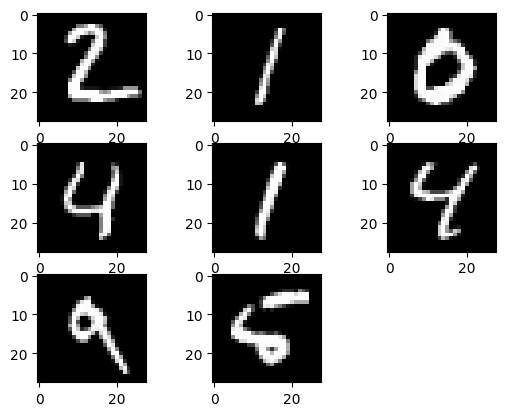

In [11]:
print(len(mod2.Input_layer))
mod2.train(x_train, y_train, 2048, 10, 0.01)
for i in range(1,9):
  plt.subplot(330+i)
  plt.imshow(x_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
print(mod2.eval(np.array([x_test[5]])))
print(y_test[5])
test(mod2, x_test, y_test, 500)

In [12]:
test(mod2, x_test, y_test, 5000)

batch: 0, accuracy: 73.72%
batch: 1, accuracy: 83.06%
